## GAMs notebook

In this notebook, various generalized additive models (GAMs) are trained.  We find that, without feature engineering, the best GAM uses all features.  The same holds true with feature engineering.  Residual plots and partial dependence plots are included to better understand the models performance.

-No feature engineering, no feature selection GAM Kaggle score: 0.08945 (3811/4318)\
-Feature engineering, no feature selection GAM Kaggle score: 0.06949 (3605/4318)

In [ ]:
import numpy as np
import pandas as pd
from pygam import LinearGAM, s, f
import matplotlib.pyplot as plt
import optuna
from optuna.trial import TrialState
import seaborn as sns
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import KFold, train_test_split

In [8]:
train = pd.read_csv("train_pp.csv")
test = pd.read_csv("test_pp.csv")
# sample = pd.read_csv("sample_submission.csv")

train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,1,36,189,82,26,101,41.0,5.017280
1,0,64,163,60,8,85,39.7,3.555348
2,0,51,161,64,7,84,39.8,3.401197
3,1,20,192,90,25,105,40.7,4.948760
4,0,38,166,61,25,102,40.6,4.990433


#### Create a baseline GAM with no feature selection and partial dependence plots

Train RMSLE is: 0.0900430951340916
Test RMSLE is: 0.08996528009806903


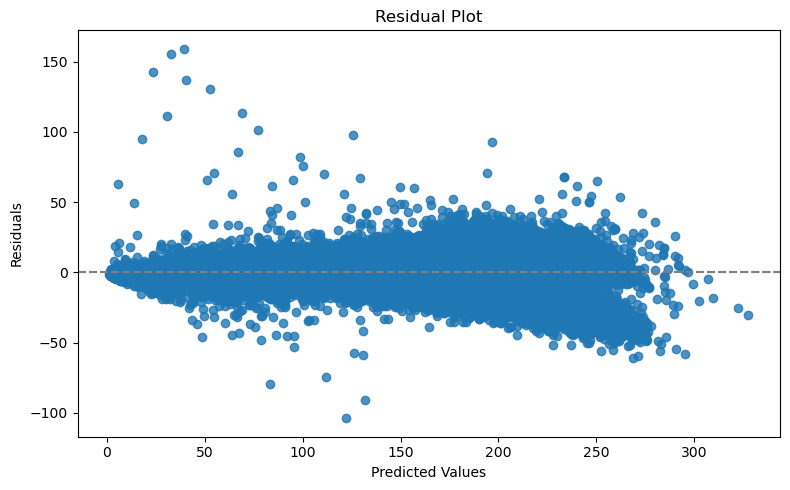


Partial Dependence Plots:


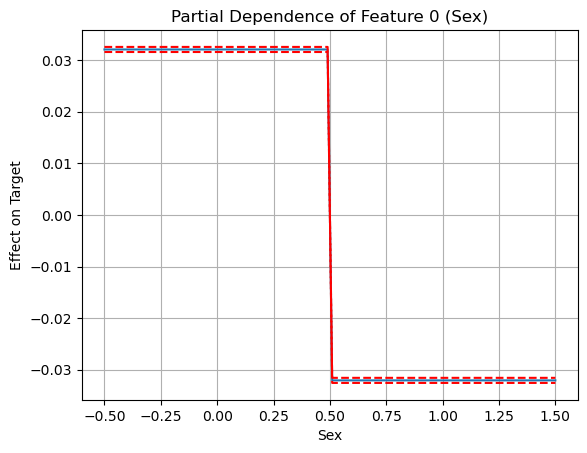

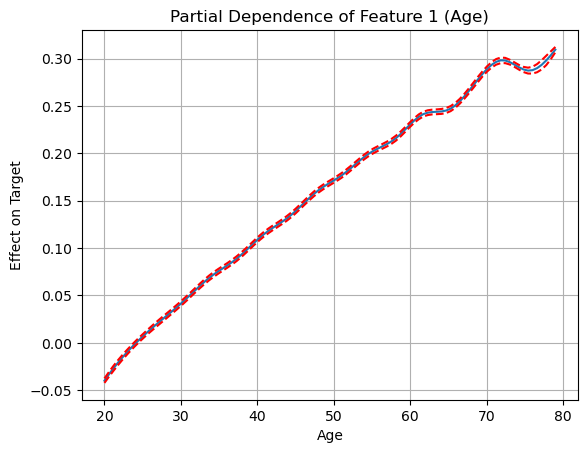

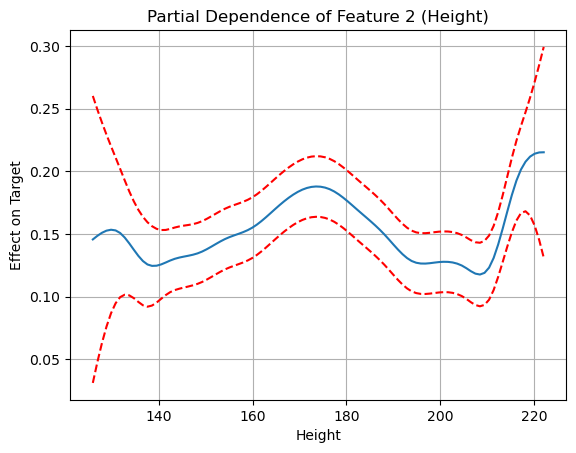

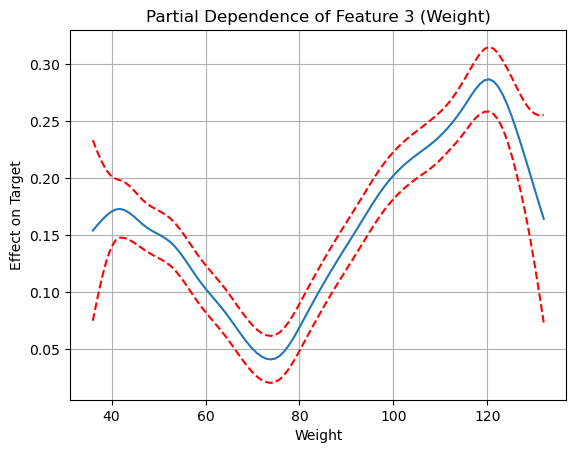

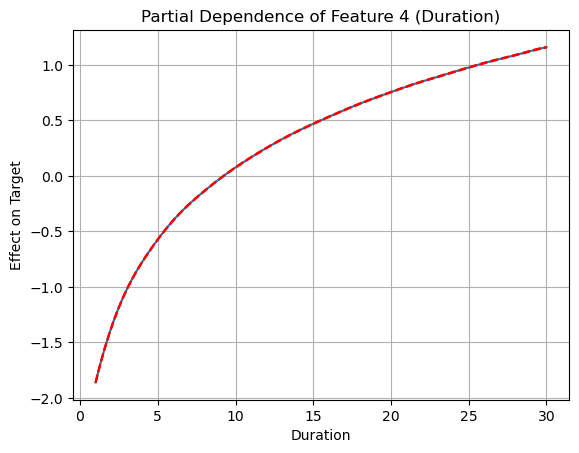

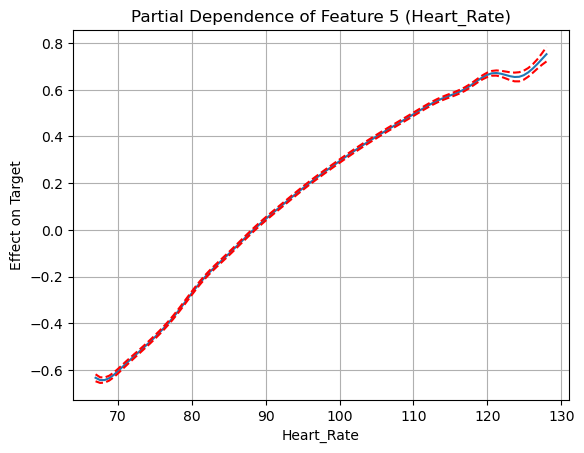

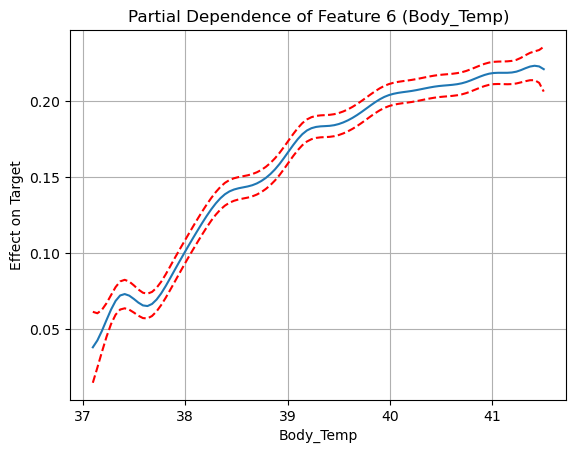

       id    Calories
0  750000   28.101439
1  750001  106.982687
2  750002   89.638921
3  750003  129.353761
4  750004   74.608806

count    250000.000000
mean         88.193629
std          62.563083
min           1.350554
25%          33.964642
50%          76.184772
75%         134.871937
max         316.788817
Name: Calories, dtype: float64


In [13]:
# Baseline GAM - Kaggle score 0.08945 private, 0.08850 public GAM_1.csv

X = train.drop(columns='Calories')
y = train['Calories']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=724)

# fit GAM
gam = LinearGAM(f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6)).fit(X_train, y_train)

# train score
train_pred = gam.predict(X_train)
print("Train RMSLE is:", rmse(train_pred,y_train))

# test score
test_pred = gam.predict(X_test)
print("Test RMSLE is:", rmse(test_pred,y_test))


# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=np.expm1(test_pred), y=np.expm1(y_test))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()



# Plot partial dependence functions
print("\nPartial Dependence Plots:")
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.figure()
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i))
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, width=0.95)[1], c='r', ls='--')
    plt.title(f'Partial Dependence of Feature {i} ({X.columns[i]})')
    plt.xlabel(X.columns[i])
    plt.ylabel('Effect on Target')
    plt.grid(True)
    plt.show()



# make the submission file!

pred = gam.predict(test)

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("GAM_1.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

#### Test all possible feature combinations to get the best GAM (without feature engineering).

In [10]:
def powerset(s):
    ''''''''''''''''
    Input: A list s.
    Output: The powerset of s minus the empty set.
    Example: s = ['a', 'b']
    list(powerset(s)) will return [['a'], ['b'], ['a', 'b']].
    '''''''''''''''
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1, 1 << x):
        yield [ss for mask, ss in zip(masks, s) if i & mask]

Find the best combination of features!  It turns out that including all features is optimal.

In [15]:
X = train.drop(columns='Calories')
y = train['Calories']

col_combo = list(powerset(X.columns.tolist()))

err = []

for feats in col_combo:
    # Cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=724)

    scores = []

    # Perform cross-validation manually
    for train_index, test_index in kf.split(X[feats]):
        X_train, X_val = X[feats].loc[train_index], X[feats].loc[test_index]
        y_train, y_val = y.loc[train_index], y.loc[test_index]

        n_features = len(feats)         # number of features
        if 'Sex' in feats:
            n_numeric = len(feats) - 1  # number of numeric features
                
        else:
            n_numeric = n_features


        if n_numeric != n_features: # i.e. using the categorical feature
            terms = f(0)
            for i in range(1, n_features):
                terms += s(i)

        else:
            terms = s(0)
            for i in range(1, n_features):
                terms += s(i)


        # fit GAM
        gam = LinearGAM(terms=terms).fit(X_train, y_train)
        predictions = gam.predict(X_val)

        
        # Calculate the score
        score = rmse(y_val, predictions)
        scores.append(score)
    

    # Calculate mean RMSLE
    err.append(np.mean(scores))
    print("Features", feats, "have mean RMSE of", np.mean(scores))


min_value = min(err) #find the min value
min_index = err.index(min_value) #find the index of the min value

print(f"Minimum value: {min_value}")
print(f"Index of minimum value: {min_index}, which corresponds to", col_combo[min_index])

Features ['Sex'] have mean RMSE of 0.9627962548978068
Features ['Age'] have mean RMSE of 0.9542897970536623
Features ['Sex', 'Age'] have mean RMSE of 0.9538286641700715
Features ['Height'] have mean RMSE of 0.9614401812306687
Features ['Sex', 'Height'] have mean RMSE of 0.9614416953588374
Features ['Age', 'Height'] have mean RMSE of 0.9525554797605551
Features ['Sex', 'Age', 'Height'] have mean RMSE of 0.952555622397865
Features ['Weight'] have mean RMSE of 0.961996950747437
Features ['Sex', 'Weight'] have mean RMSE of 0.9617882625797938
Features ['Age', 'Weight'] have mean RMSE of 0.9528473731842654
Features ['Sex', 'Age', 'Weight'] have mean RMSE of 0.952783657198752
Features ['Height', 'Weight'] have mean RMSE of 0.9595072445891173
Features ['Sex', 'Height', 'Weight'] have mean RMSE of 0.9589944376083754
Features ['Age', 'Height', 'Weight'] have mean RMSE of 0.9514827760945198
Features ['Sex', 'Age', 'Height', 'Weight'] have mean RMSE of 0.9512940120430945
Features ['Duration'] have

## Feature engineering
Add product terms, body mass index (BMI), and Body_Temp squared

In [17]:
numerical_features = ["Age","Height","Weight","Duration","Heart_Rate","Body_Temp"]

def add_feats(df, numerical_features):
    ''''''''''
    Inputs: dataframe df
    Output: the modified dataframe with cross terms, BMI, and Body_Temp squared
    '''''''''
    df_new = df.copy()

    features = df_new.columns

    if 'id' in features:
        df_new = df_new.drop(columns=['id'])
    
    if 'Calories' in features:
        df_new = df_new.drop(columns=['Calories'])

    df_new['BMI'] = df_new['Weight']/((df_new['Height']/100)**2)
    df_new['Body_Temp_-_min_sq'] = (df_new['Body_Temp']-df_new['Body_Temp'].min())**2

    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):  
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
            #cross_term_name = f"{feature1}_divided_{feature2}"
            #df_new[cross_term_name] = df_new[feature1] / df_new[feature2]

    return df_new

Create a baseline GAM using all terms.

Train RMSLE is: 0.07038723289768001
Test RMSLE is: 0.07051648321204486


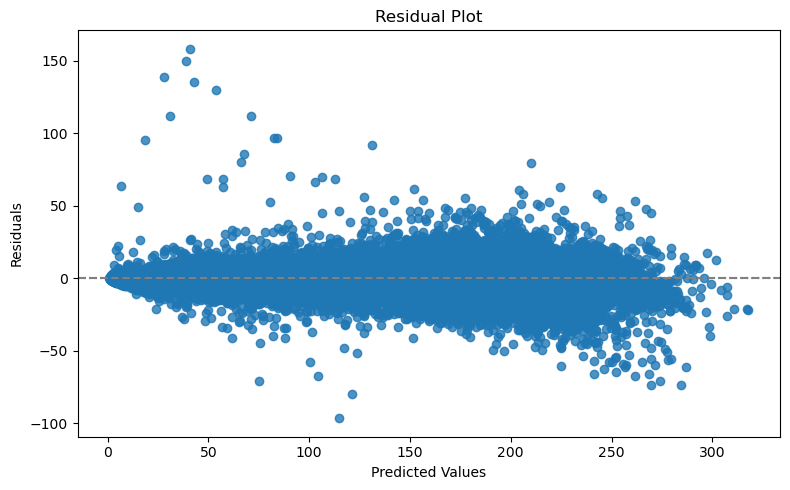


Partial Dependence Plots:


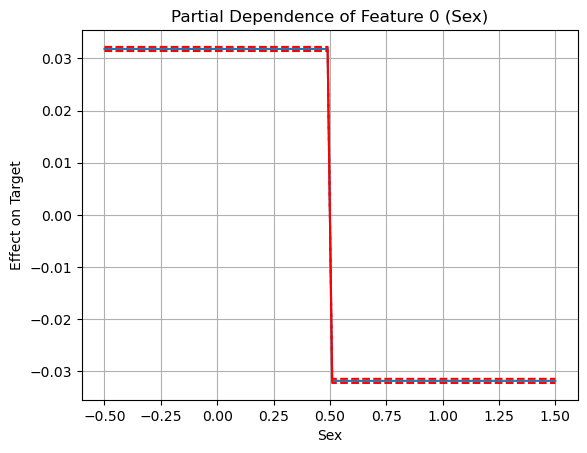

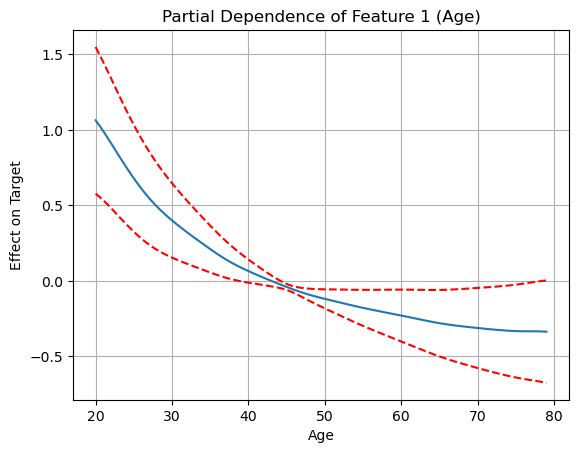

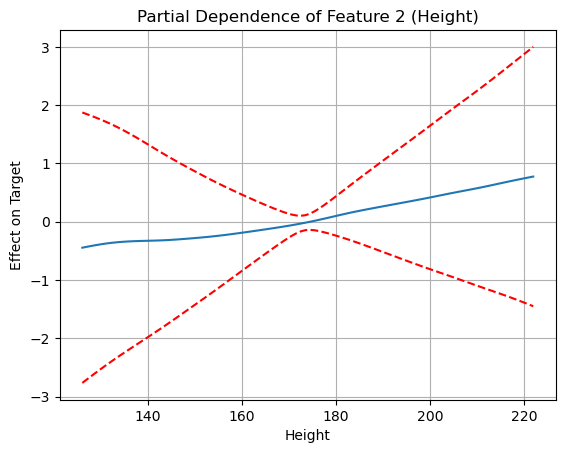

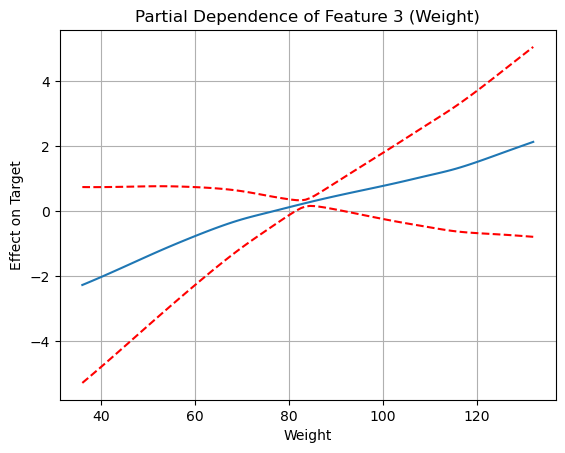

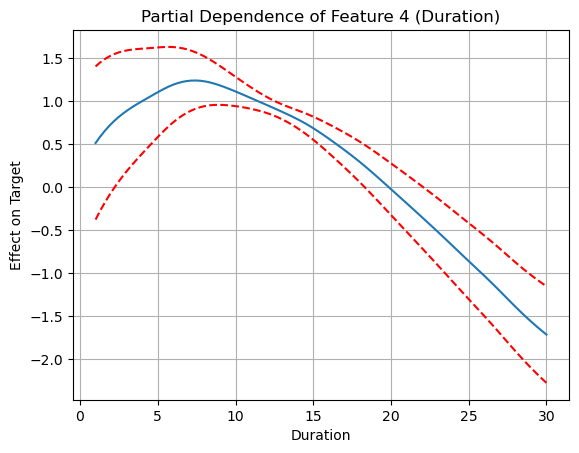

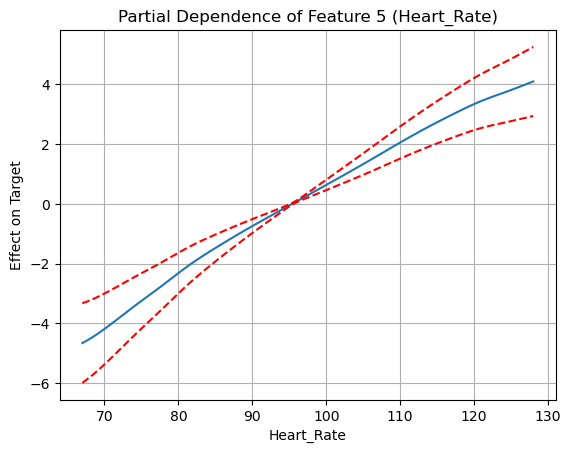

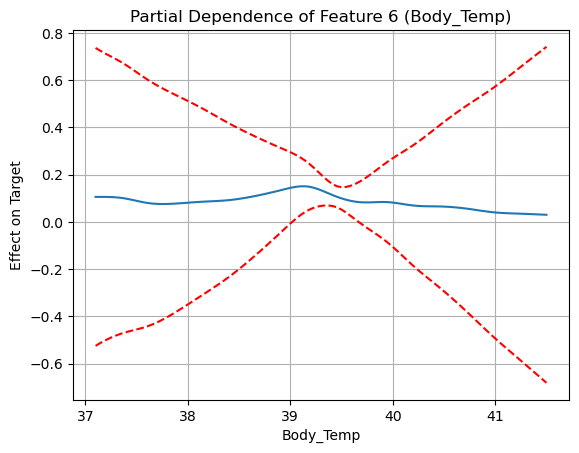

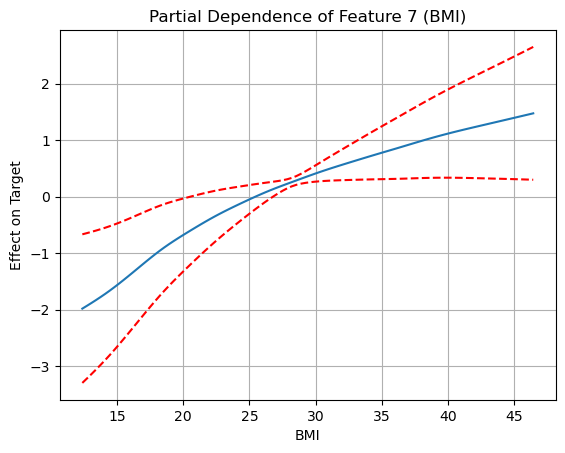

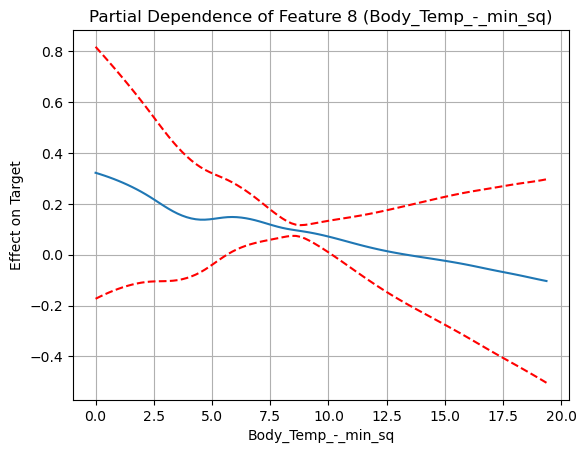

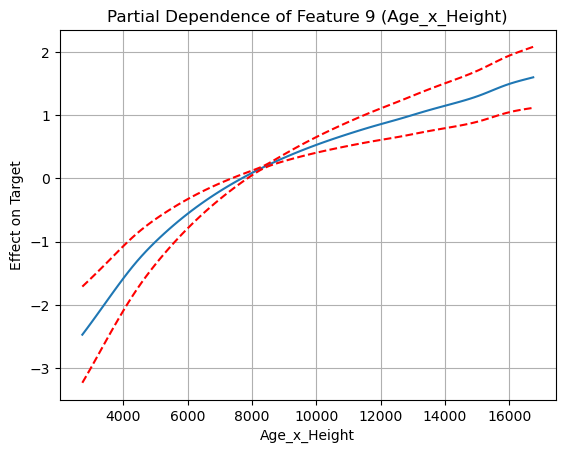

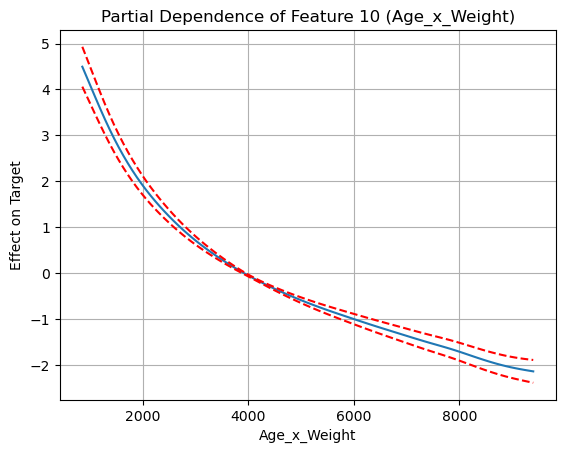

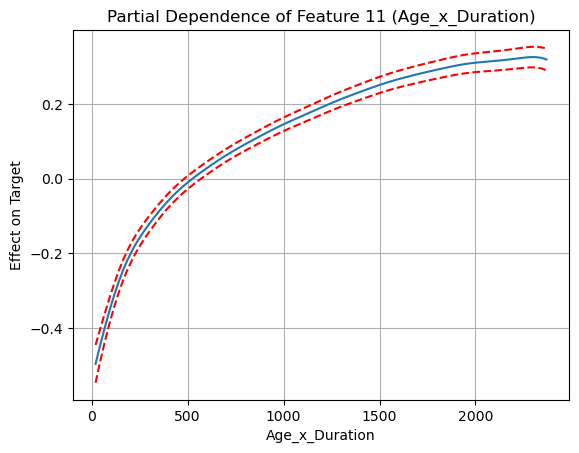

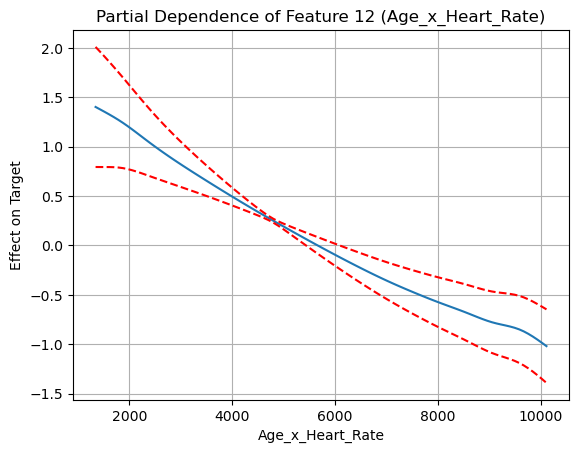

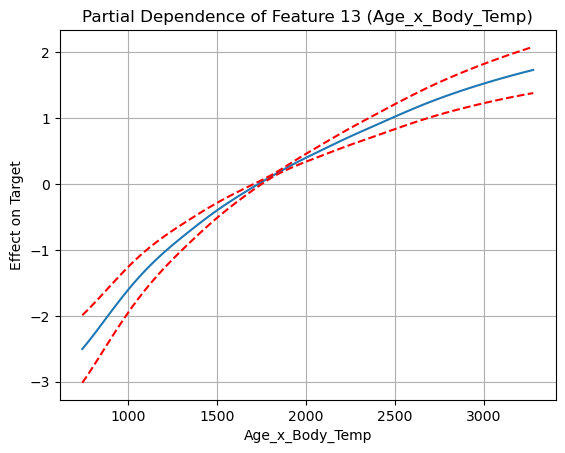

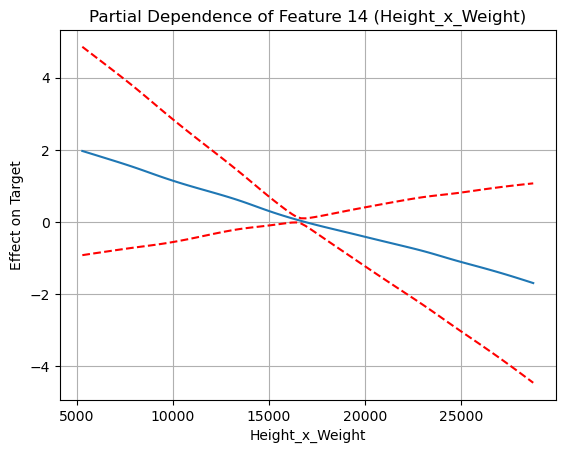

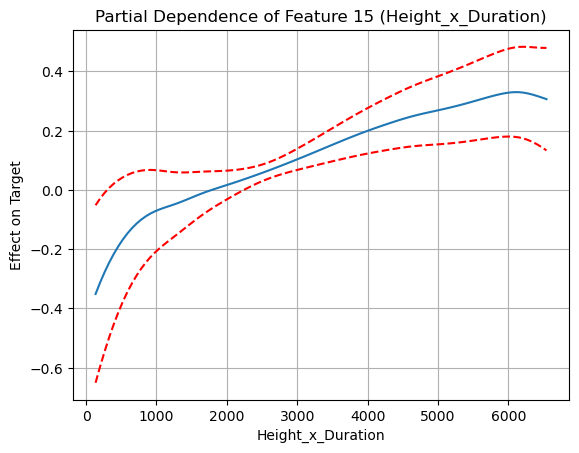

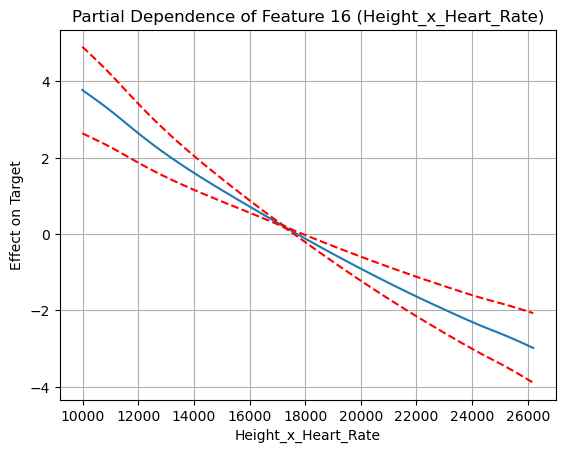

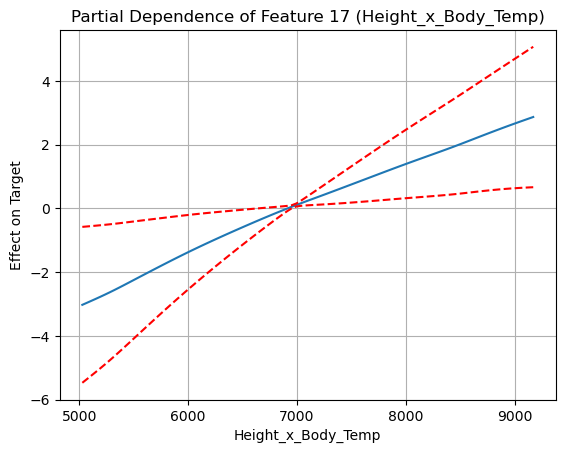

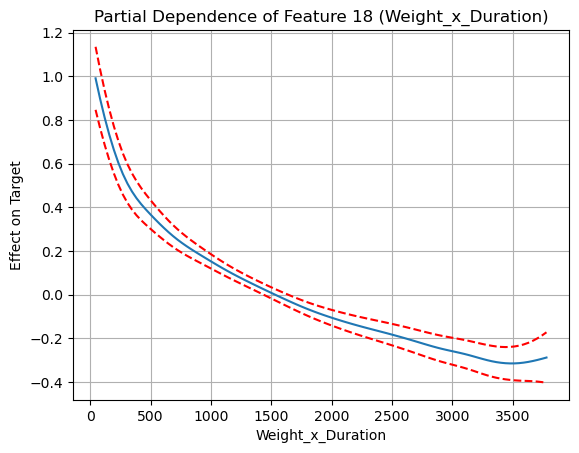

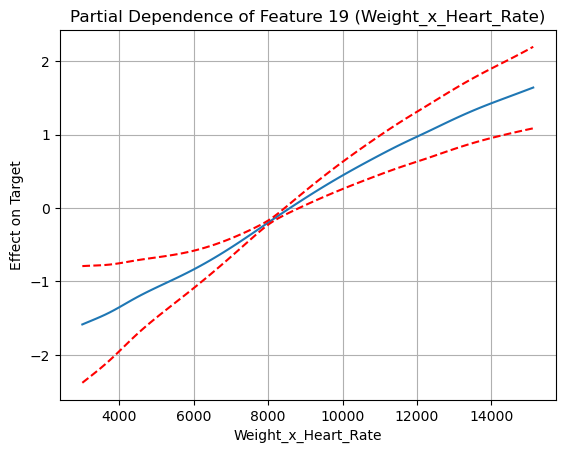

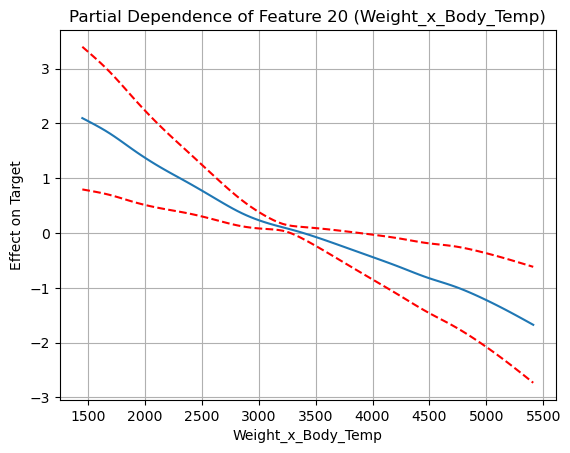

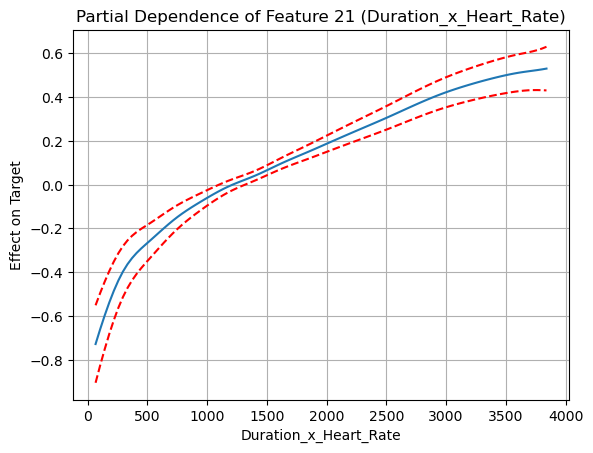

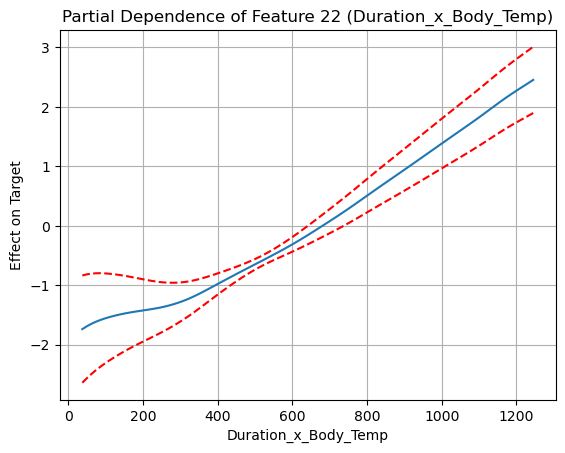

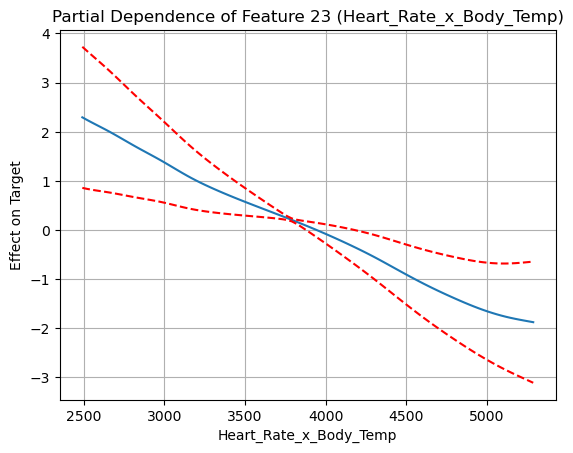

       id    Calories
0  750000   27.368448
1  750001  106.663205
2  750002   92.766496
3  750003  130.625363
4  750004   74.856047

count    250000.000000
mean         88.196772
std          62.371276
min           0.827796
25%          33.978953
50%          76.444081
75%         135.380204
max         315.811814
Name: Calories, dtype: float64


In [18]:
# Baseline GAM (w/ feature engineering) - Kaggle score 0.06949 private, 0.06884 public GAM_3.csv

X = add_feats(train, numerical_features)
y = train['Calories']

test_mod = add_feats(test, numerical_features)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=724)

n_numeric = len(X.columns) - 1  # number of numeric features
n_features = X.shape[1] # number of features

# fit GAM
terms = f(0)
for i in range(1, n_features):
    terms += s(i)

gam = LinearGAM(terms=terms).fit(X_train, y_train)



# train score
train_pred = gam.predict(X_train)
print("Train RMSLE is:", rmse(train_pred,y_train))

# test score
test_pred = gam.predict(X_test)
print("Test RMSLE is:", rmse(test_pred,y_test))


# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=np.expm1(test_pred), y=np.expm1(y_test))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


# Plot partial dependence functions
print("\nPartial Dependence Plots:")
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.figure()
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i))
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, width=0.95)[1], c='r', ls='--')
    plt.title(f'Partial Dependence of Feature {i} ({X.columns[i]})')
    plt.xlabel(X.columns[i])
    plt.ylabel('Effect on Target')
    plt.grid(True)
    plt.show()



# make the submission file!

pred = gam.predict(test_mod)

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("GAM_3.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

In [40]:
2 ** len(X.columns)

16777216

There is a total of $2^{24}-1=16777215$ feature combinations.  There is not enough time to test all possible combinations, so using Optuna to test different selections of features, we see that using all features is likely optimal.  

In [ ]:
X = add_feats(train, numerical_features)
y = train['Calories']

# split off a hold‐out for final evaluation (optional but recommended)
X_trainval, X_holdout, y_trainval, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=724
)

cat_col      = 'Sex'
numeric_cols = [c for c in X_trainval.columns if c != cat_col]

# 2. Define the Optuna objective
# -------------------------------
def objective(trial):
    # 2a) Feature‐selection: for each column, decide to include (1) or drop (0)
    # The first column is the only categorical category, which will always be included
    mask = []
    for col in numeric_cols:
        include = trial.suggest_categorical(f"use_{col}", [0, 1])
        mask.append(include)
    mask = np.array(mask, dtype=bool)

    # ensure no duplicate trials
    for t in trial.study.trials:
        if t.state != TrialState.COMPLETE:
            continue
        if t.params == trial.params:
            # mark this trial as pruned so it won't count
            raise optuna.TrialPruned(f"duplicate of trial #{t.number}")

    
    # If no features selected, bail out
    if mask.sum() == 0:
        return float("inf")
    
    selected = [col for col, use in zip(numeric_cols, mask) if use] + [cat_col]
    
    X_sub = X_trainval[selected]
    
    # 2c) Build your GAM
    #    We’ll create one spline term for each selected feature.
    spline_terms = f(0)
    for i in range(1, sum(mask)):
        spline_terms += s(i)


    gam = LinearGAM(spline_terms)
    
    # 2d) Fit on a train/validation split
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_sub, y_trainval, test_size=0.25, random_state=412
    )
    gam.fit(X_tr, y_tr)
    
    # 2e) Compute validation error
    y_pred = gam.predict(X_val)
    return rmse(y_val, y_pred)

# 3. Create and run the study
# ----------------------------
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(),
    study_name='GAM_feat_select',
    storage="sqlite:///GAMs2.db",
    load_if_exists=True,
)
study.optimize(objective, n_trials=10000, timeout=28800)

# 4. Inspect the results
# ----------------------
print("Best RMSLE:", study.best_value)
print("Feature-mask:")
best_mask = [p[1] for p in study.best_trial.params.items()]
selected_features = [col for col, use in zip(X_trainval.columns, best_mask) if use] + [cat_col]
print(selected_features)

# 5. Retrain final GAM on all train+val with chosen features
X_final = X_trainval[selected_features]

final_terms = s(0)
for i in range(1, len(selected_features)-1):
    final_terms += s(i)
final_terms += f(len(selected_features)-1)
final_gam = LinearGAM(final_terms).fit(X_final, y_trainval)

# Evaluate on the hold‐out
X_hold = X_holdout[selected_features]
print("Hold-out RMSLE:",
      rmse(y_holdout, final_gam.predict(X_hold)))


[I 2025-06-20 00:53:10,498] Using an existing study with name 'GAM_feat_select' instead of creating a new one.
[I 2025-06-20 00:54:10,044] Trial 856 finished with value: 0.06989885455648781 and parameters: {'use_Age': 1, 'use_Height': 1, 'use_Weight': 1, 'use_Duration': 0, 'use_Heart_Rate': 0, 'use_Body_Temp': 1, 'use_BMI': 0, 'use_Body_Temp_-_min_sq': 1, 'use_Age_x_Height': 1, 'use_Age_x_Weight': 1, 'use_Age_x_Duration': 1, 'use_Age_x_Heart_Rate': 1, 'use_Age_x_Body_Temp': 0, 'use_Height_x_Weight': 1, 'use_Height_x_Duration': 1, 'use_Height_x_Heart_Rate': 1, 'use_Height_x_Body_Temp': 1, 'use_Weight_x_Duration': 1, 'use_Weight_x_Heart_Rate': 1, 'use_Weight_x_Body_Temp': 1, 'use_Duration_x_Heart_Rate': 1, 'use_Duration_x_Body_Temp': 0, 'use_Heart_Rate_x_Body_Temp': 1}. Best is trial 777 with value: 0.06979235163292526.
[I 2025-06-20 00:55:06,309] Trial 857 finished with value: 0.06988044851736046 and parameters: {'use_Age': 1, 'use_Height': 1, 'use_Weight': 1, 'use_Duration': 1, 'use_He

Best RMSLE: 0.06978432829263405
Feature-mask:
['Age', 'Height', 'Weight', 'Heart_Rate', 'BMI', 'Body_Temp_-_min_sq', 'Age_x_Height', 'Age_x_Weight', 'Age_x_Duration', 'Age_x_Heart_Rate', 'Age_x_Body_Temp', 'Height_x_Weight', 'Height_x_Heart_Rate', 'Height_x_Body_Temp', 'Weight_x_Duration', 'Weight_x_Heart_Rate', 'Weight_x_Body_Temp', 'Duration_x_Heart_Rate', 'Heart_Rate_x_Body_Temp', 'Sex_male']
Hold-out RMSLE: 0.07066036238222406


In [ ]:
# Kaggle score 0.06949 private, 0.06896 public GAM_5.csv

# ['Age', 'Height', 'Weight', 'Heart_Rate', 'Body_Temp_-_min_sq', 'Age_x_Height', 'Age_x_Weight', 'Age_x_Duration', 'Age_x_Heart_Rate', 'Age_x_Body_Temp', 'Height_x_Weight', 'Height_x_Heart_Rate', 'Height_x_Body_Temp', 'Weight_x_Duration', 'Weight_x_Heart_Rate', 'Weight_x_Body_Temp', 'Duration_x_Heart_Rate', 'Heart_Rate_x_Body_Temp', 'Sex_male']


# train/test split
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=724)


# fit GAM
gam = LinearGAM(terms=final_terms).fit(X_train, y_train)



# train score
train_pred = gam.predict(X_train)
print("Train RMSLE is:", rmse(train_pred,y_train))

# test score
test_pred = gam.predict(X_test)
print("Test RMSLE is:", rmse(test_pred,y_test))



# make the submission file!

pred = gam.predict(test_mod[selected_features])

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("GAM_5.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

Train RMSLE is: 0.07048654618138339
Test RMSLE is: 0.07066550189120355
       id    Calories
0  750000   27.364811
1  750001  106.214864
2  750002   92.986707
3  750003  130.838498
4  750004   74.684575

count    250000.000000
mean         88.196367
std          62.366382
min           0.834341
25%          33.977649
50%          76.441791
75%         135.409946
max         316.146696
Name: Calories, dtype: float64
